# Описание проекта

Задача -  создание модели которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. 

# 1. Подготовка данных

In [1]:
# Подгрузка библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#### Посмотрим на данные и оценим колонки с пропусками более 2 %

In [2]:
# Посмотрим на данные
train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv', sep=',')
test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv', sep=',')
full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv', sep=',')

for data, name in zip([train, test, full], ['train','test','full']):
    print(f'Размер датафрейма {name} - {data.shape}')    
    for column in (data.columns):
        if data[column].isna().sum()/len(data[column]) > 0.02:
            print("Пропусков по колонке:", column," - ", data[column]\
                                    .isna().sum(), ", доля: {:.2%}"\
                                    .format(data[column].isna().sum()/len(data[column]))) 
    #display(data.info())
    print("------------------------------------------- ")

Размер датафрейма train - (16860, 87)
Пропусков по колонке: final.output.concentrate_sol  -  370 , доля: 2.19%
Пропусков по колонке: final.output.recovery  -  1521 , доля: 9.02%
Пропусков по колонке: primary_cleaner.input.sulfate  -  1307 , доля: 7.75%
Пропусков по колонке: primary_cleaner.input.depressant  -  1262 , доля: 7.49%
Пропусков по колонке: primary_cleaner.input.xanthate  -  985 , доля: 5.84%
Пропусков по колонке: primary_cleaner.output.concentrate_pb  -  358 , доля: 2.12%
Пропусков по колонке: primary_cleaner.output.concentrate_sol  -  636 , доля: 3.77%
Пропусков по колонке: rougher.calculation.au_pb_ratio  -  1242 , доля: 7.37%
Пропусков по колонке: rougher.input.feed_rate  -  513 , доля: 3.04%
Пропусков по колонке: rougher.input.feed_size  -  417 , доля: 2.47%
Пропусков по колонке: rougher.input.floatbank10_sulfate  -  1044 , доля: 6.19%
Пропусков по колонке: rougher.input.floatbank10_xanthate  -  346 , доля: 2.05%
Пропусков по колонке: rougher.input.floatbank11_sulfate  -

<u><b>Промежуточный вывод</b></u> 
* Имеем в наличии три разных набора данных, 1 суммарный по 2 другим которые имеют имена test и train. Во всех данных наблюдаются пропуски, имеется удобная колонка с датой которая потом станет индексом для выравнивания данных. Целевые признаки для обработки будут 'final.output.recovery', rougher.output.recovery.
* Типы данных проблем не имеют, кроме колонки date её надо преобразовать в формат времени.

### Функция расчет Recovery по формуле  
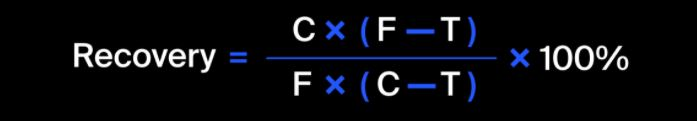

In [3]:
# Функция расчет Recovery по формуле  

# C — доля золота в концентрате после флотации/очистки;        ---- rougher.output.concentrate_au
# F — доля золота в сырье/концентрате до флотации/очистки;     ---- rougher.input.feed_au
# T — доля золота в отвальных хвостах после флотации/очистки.  ---- rougher.output.tail_au
def recovery_func(input_au, output_au, teil_au):
    try:
        rec_out = (((output_au * (input_au - teil_au)) / (input_au * (output_au - teil_au))) * 100)
        return(rec_out)            
    except:
        return(0)           

        


In [4]:
# удалим все пропуска в данных для подсчета формулой правильности расчет recovery и соаздадим датафрейм для проверки
train_test = train.dropna()

In [5]:
# проверям правильнось вычисления эффективности обогащения (признак rougher.output.recovery)
train_test['recovery_calculated'] = recovery_func(train_test['rougher.input.feed_au'], train_test['rougher.output.concentrate_au'], train_test['rougher.output.tail_au'])
# оценим данные расчета и старые
display(train_test[['rougher.output.recovery', 'recovery_calculated']].head(10)) 


C:\Users\Mex\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rougher.output.recovery,recovery_calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


In [6]:
# Оценим МАЕ
MAE = mean_absolute_error(train_test['rougher.output.recovery'], train_test['recovery_calculated'])
print(f'МАЕ вычесленного значения и начального значения равно: {MAE}')

МАЕ вычесленного значения и начального значения равно: 9.555596961987514e-15


<u><b>Промежуточный вывод</b></u> 
* Функция расчёта оказалась весьма точной, наша средняя абсолютная ошибка имеет очень маленькое значение. Этой функцией можно заполнить пропуски целевого признака

In [7]:
# заполним все пропуски по столбцам
# Технологические данные меняются во времени плавно и непрерывно и в нормальном режиме не дают выбросов. 
# Если выброс, то это или авария, или датчик поломался. 
# Поэтому метод ffill с точки зрения природы данных будет оптимальным.
train = train.fillna(method='ffill')
# заполним пропуски в полной выборке
full = full.fillna(method='ffill')
# удалим значения признака с величиной 0 для правильной работы формулы вычсиления 
train = train.loc[train['rougher.input.feed_au'] > 0]


Удаление значений меньше 0 нужно для того, чтобы потом не появились NaN значения в данных.

In [8]:
# поправим значения в столбце 'rougher.output.recovery' по нашей расчетной формуле
train['rougher.output.recovery'] = recovery_func(train['rougher.input.feed_au'], train['rougher.output.concentrate_au'], train['rougher.output.tail_au'])

Исправим ошибочные значения в целевом столбце.

#### Найдем колонки которых нет в тестовом датафрейме

In [9]:
# найдем колонки которых нет в тестовом датафрейме
display(pd.Series(train.columns[~train.columns.isin(test.columns)]))

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
17        rougher.calculation.sulfate_to_au_conc

<u><b>Промежуточный вывод</b></u>
* судя по колонкам в тестовой выборке нет много интересных колонок с содержанием металов на разных стадиях обработки. Они нам нужны и мы их добавим.

### Предобработка данных

Изменим формат колонки дата и назначим ее индексом для удобства сращивания признаков по дате.

In [10]:
# изменим формат
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
full['date'] = pd.to_datetime(full['date'])
# назначим индексы
train = train.set_index('date', inplace=False)
test = test.set_index('date', inplace=False)
full = full.set_index('date', inplace=False)

Добавим все недостающие целевые колонки в тестовую выборку

In [11]:
test[['rougher.output.recovery', 'final.output.recovery']] = full[['rougher.output.recovery', 'final.output.recovery']]

Удалим лишние колонки из трейна. чтобы и обучаться и тестироваться на одинаковом наборе признаков.

In [12]:
# создадим список имен колонок которые нужно удалить из датафрейм трейн
name_columns_test = pd.Series(train.columns[~train.columns.isin(test.columns)])
# удалим колонки с неправильными данными 
train = train.drop(name_columns_test, axis=1)

In [13]:
# удалим пропуски из тестового набора
test = test.dropna()
# сохраним размеры для оценки
test_old = len(test)
train_old = len(train)
# сравним их
print(f'Размер учебной выборки {train.shape}, что равно {round(((train.shape[0] / full.shape[0]) * 100),2)} %')
print(f'Размер тестовой выборки {test.shape}, что равно {round(((test.shape[0] / full.shape[0]) * 100),2)} %')
print(f'Размер полной выборки {full.shape}')

Размер учебной выборки (15647, 54), что равно 68.88 %
Размер тестовой выборки (5383, 54), что равно 23.7 %
Размер полной выборки (22716, 86)


Оценим размеры наших выборок

In [14]:
train.shape, test.shape

((15647, 54), (5383, 54))

<u><b>Промежуточный вывод</b></u>
* Была проведена предобработка данных, преобразован тип даты в индексы, выборки трейн и тест сравнены и выровнены по наличию колонок в датасете тест.

# 2. Анализ данных

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

Создадим полезную функцию

In [15]:
# Функция отрисовки концентрации металов
def plot_function(ag, pb, au, title, df, mode):
    """
    функция отрисовки
    ag, pb, au --- которая принимает как параметры - нужные нам для отобраения металы 
    title ---- Название графика для красоты и кошерности
    df -  датафрейм из котрого пойдут данные
    mode -  режим переключения на разные графики, kde или hist
    True - hist
    False - kde
    
    """
    for column in [ag, pb, au]:
        if mode == True:
            df[column].plot(kind='hist',figsize=(10, 8), legend = True, alpha=0.8)
            plt.legend(['Сырье','Черновой', 'Финальный'])
            plt.ylabel('Плотность')
            plt.xlabel('Концентрация')
            plt.title(title) 
        else:            
            df[column].plot.kde(figsize=(14, 8), legend = True)
            plt.legend(['Серебро','Свинец','Золото'])
            plt.ylabel('Плотность')
            plt.xlabel('Концентрация')
            plt.title(title)      
       
  

#### Посмотрим на концентрацию на различных этапах очистки

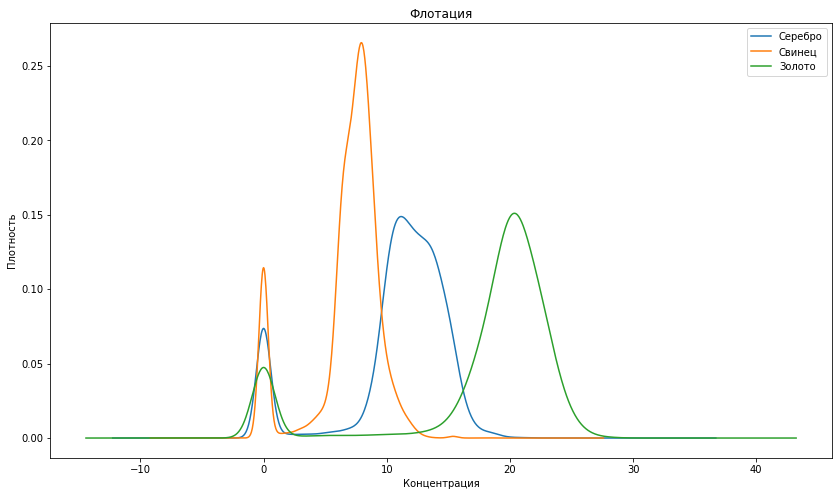

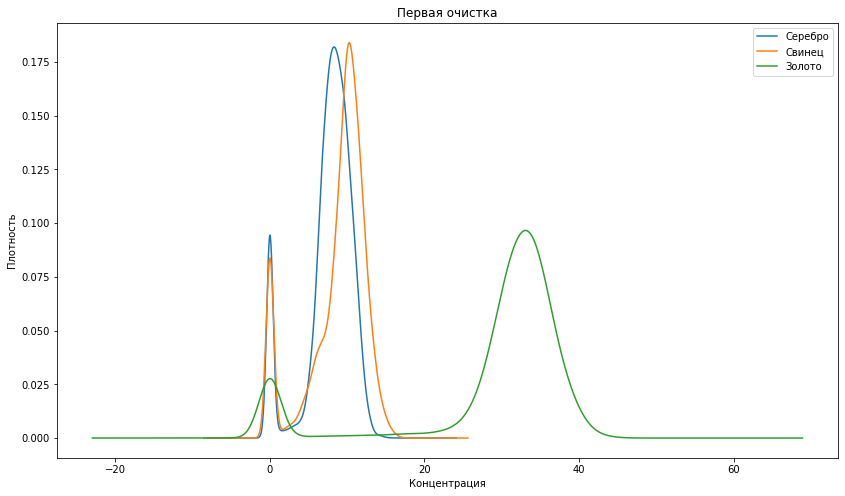

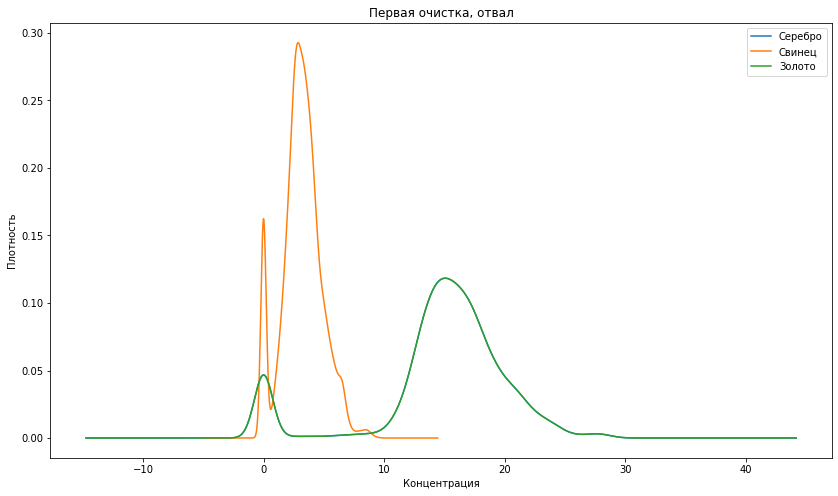

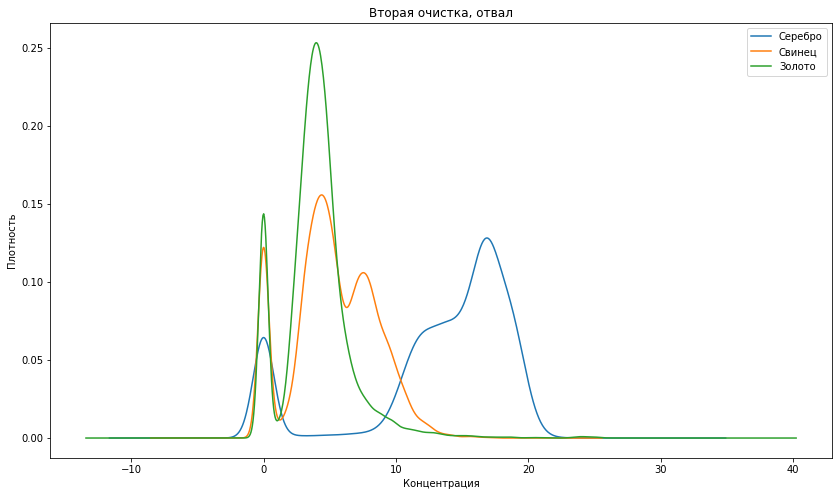

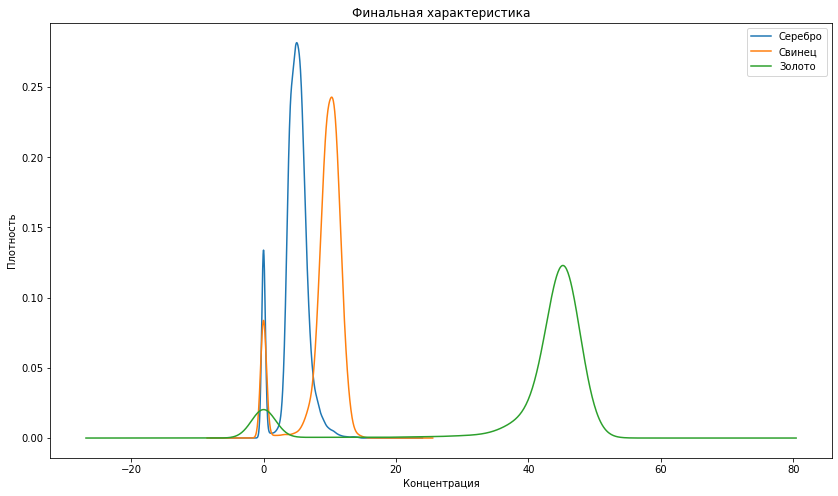

In [16]:
# Посмотрим на концентрацию на различных этапах очистки 
plot_function('rougher.output.concentrate_ag', 
              'rougher.output.concentrate_pb', 
              'rougher.output.concentrate_au', 
              'Флотация', full, False)
plt.show()
plot_function('primary_cleaner.output.concentrate_ag', 
              'primary_cleaner.output.concentrate_pb', 
              'primary_cleaner.output.concentrate_au', 
              'Первая очистка', full, False)
plt.show()
plot_function('primary_cleaner.output.tail_ag', 
              'primary_cleaner.output.tail_pb', 
              'primary_cleaner.output.tail_ag', 
              'Первая очистка, отвал', full, False)
plt.show()
plot_function('secondary_cleaner.output.tail_ag', 
              'secondary_cleaner.output.tail_pb', 
              'secondary_cleaner.output.tail_au', 
              'Вторая очистка, отвал', full, False)
plt.show()
plot_function('final.output.concentrate_ag', 
              'final.output.concentrate_pb', 
              'final.output.concentrate_au', 
              'Финальная характеристика', full, False)

Видна нормальная с точки зрения логики характеристика целевого метала - золота, на разных стадиях очистки.
* Флотация -все примерно на 1 уровне смешивания.
* 1 очистка - золото уже явно отделилось, а остальные металы так и остались в группе
* Отвалы 1 и 2 этапа - имеют содержание всех металов, разное концентрации.
* Финальная очистка - золото уже хорошо отделено, видны выбросы в 0 посмотрим на них ниже.


#### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

count    15647.000000
mean        60.625976
std         27.298125
min          9.659576
25%         48.228361
50%         54.873428
75%         66.062737
max        484.967466
Name: rougher.input.feed_size, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


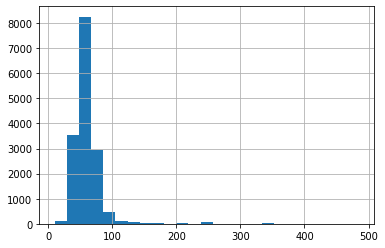

In [17]:
# Оценим данные по размерам гранул на учебной выборке
train['rougher.input.feed_size'] = train['rougher.input.feed_size'].astype('float')
print(train['rougher.input.feed_size'].describe())
print(train['rougher.input.feed_size'].hist(bins=25))
plt.show()


count    5383.000000
mean       56.338644
std        21.836788
min         0.046369
25%        43.913766
50%        50.924232
75%        62.364984
max       477.445473
Name: rougher.input.feed_size, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


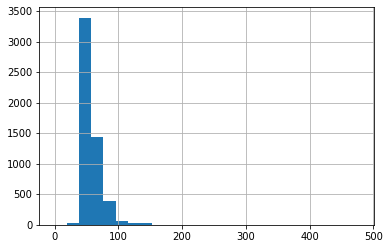

In [18]:
# Оценим данные по размерам гранул на тестовой выборке
print(test['rougher.input.feed_size'].describe())
print(test['rougher.input.feed_size'].hist(bins=25))
plt.show()

Text(0.5, 1.0, 'Сравнение гранул')

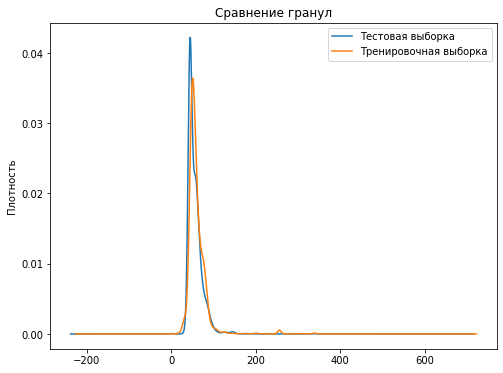

In [19]:
# Отрисуем наши размеры гранул на 1 графике
test['rougher.input.feed_size'].plot.kde(figsize=(8, 6), legend = True)
train['rougher.input.feed_size'].plot.kde(figsize=(8, 6), legend = True)
plt.legend(['Тестовая выборка', 'Тренировочная выборка'])
plt.ylabel('Плотность')
plt.title('Сравнение гранул')

<u><b>Промежуточный вывод</b></u>
* Основная масса гранул >75 % имеет схожие характеристики по размерам и разбросам. Есть небольшая разница по максимум на тестовой выборке. Позднее я применю Scaler, но он все равно не даст ощутимого прироста информации.

#### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [20]:
# Подсчитаем суммарную концентрацию всех веществ на разных стадиях
full['summary_rougher'] = sum(full['rougher.output.concentrate_'+ elem]
                             for elem in ['ag', 'au', 'pb', 'sol'])
full['summary_cleaner'] = sum(full['primary_cleaner.output.concentrate_'+ elem]
                             for elem in ['ag', 'au', 'pb', 'sol'])
full['summary_final'] = sum(full['final.output.concentrate_'+ elem]
                             for elem in ['ag', 'au', 'pb', 'sol'])

display(full[['summary_rougher', 'summary_final', 'summary_cleaner']].sort_values(by='summary_final', ascending=False).head(4))

,summary_rougher,summary_final,summary_cleaner
date,,,
2016-04-21 04:00:00,77.132774,80.210644,61.339839
2016-11-20 17:59:59,69.682021,79.977670,63.988540
2016-11-20 16:59:59,67.983705,79.912473,64.830880
2016-04-21 06:00:00,77.105621,79.706640,23.714882


Судя по всему имеем нормальную форму данных, рост от начального этапа к финальному. Но есть выбросы в 0 области.

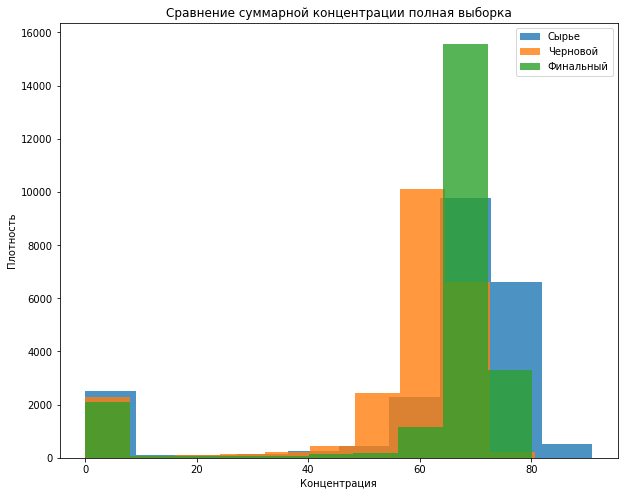

In [21]:
# Отрисуем наши концентрации по стадиям
plot_function('summary_rougher', 
              'summary_cleaner', 
              'summary_final', 
              'Сравнение суммарной концентрации полная выборка', full, True)

Очистим выбросы и в тесте и трейне по индексам(дате) из полной выборки

In [22]:
# сохраним все индексы по 3 разным суммам
df1 = full[full['summary_rougher'] == 0]
df2 = full[full['summary_cleaner'] == 0]
df3 = full[full['summary_final'] == 0]

# найем их в общем датафрейме
index_train_1 = pd.Series(train.index[train.index.isin(df1.index)])
index_train_2 = pd.Series(train.index[train.index.isin(df2.index)])
index_train_3 = pd.Series(train.index[train.index.isin(df3.index)])
# объеденим в 1 список
total_index_train  = pd.concat([index_train_1, index_train_2, index_train_3])

# найем их в общем датафрейме
index_test_1 = pd.Series(test.index[test.index.isin(df1.index)])
index_test_2 = pd.Series(test.index[test.index.isin(df2.index)])
index_test_3 = pd.Series(test.index[test.index.isin(df3.index)])
# объеденим в 1 список
total_index_test  = pd.concat([index_test_1, index_test_2, index_test_3])

# очистим train
train = train.drop(total_index_train)
# очистим test
test = test.drop(total_index_test)

print(f'Размер выборки train сократился на {train_old - (len(train))} значения')
print(f'Размер выборки test сократился на {test_old - (len(test))} значения')

Размер выборки train сократился на 621 значения
Размер выборки test сократился на 193 значения


#### вот тут какая то беда  <a id='1'></a>


In [23]:
# Функция для очистки
def cleaner(data):
    column_name = pd.Series(data.columns)
#    column_name = list(data.columns)
    old_lenges = len(data)    
    for col in (column_name):
        Q1 =  data[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        data = data[(data[col] > (Q1-3*IQR)) & (data[col] < (Q1+3*IQR))]
    print(f'Старый размер фрейма {old_lenges}')
    print(f'Новый размер фрейма {len(data)}')     
    return data

# это для оценки насколько сильно режутся данные, как то это не по-нашему))
train_new_new_temp = cleaner(test)

Старый размер фрейма 5190
Новый размер фрейма 1070


In [24]:
list(data.columns)

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

Оценим выбросы в rougher.output.recovery по train и test

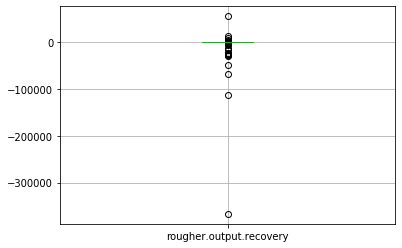

In [25]:
# train
train.boxplot(column='rougher.output.recovery')

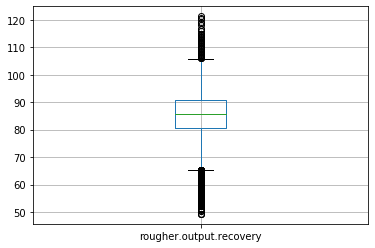

In [26]:
# очистим выбросы 
Q1 =  train['rougher.output.recovery'].quantile(0.25)
Q3 = train['rougher.output.recovery'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['rougher.output.recovery'] > (Q1-3*IQR)) & (train['rougher.output.recovery'] < (Q3+3*IQR))]
train.boxplot(column="rougher.output.recovery")


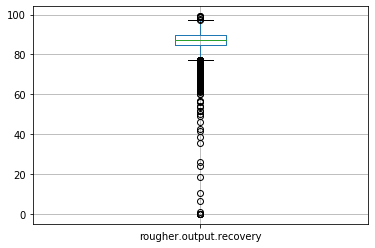

In [27]:
# test
test.boxplot(column='rougher.output.recovery')

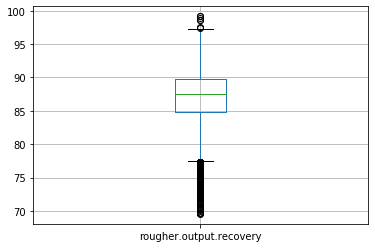

In [28]:
# Очистка test
Q1 =  test['rougher.output.recovery'].quantile(0.25)
Q3 = test['rougher.output.recovery'].quantile(0.75)
IQR = Q3 - Q1
test = test[(test['rougher.output.recovery'] > (Q1-3*IQR)) & (test['rougher.output.recovery'] < (Q3+3*IQR))]
test.boxplot(column="rougher.output.recovery")

In [29]:
print(f'Размер выборки train сократился с начального {train_old} на {train_old - (len(train))} значения')
print(f'Размер выборки test сократился с начального {test_old} на {test_old - (len(test))} значения')

Размер выборки train сократился с начального 15647 на 909 значения
Размер выборки test сократился с начального 5383 на 266 значения


# 3. Модель

Функция sMAPE  по формула 
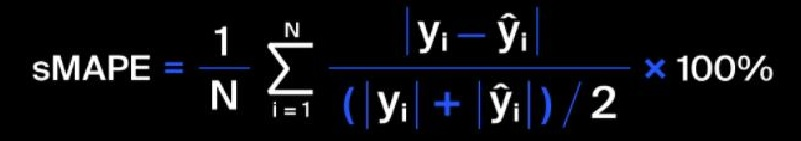


In [30]:
# sMape функция
def smape(valid, predict):
    """
    функция расчете метрики sMAPE
    valid -  проверочные данные
    predict - предсказанные данные
    
    """
    smape_out = 1/len(valid) * np.sum((2 * np.abs(valid - predict) / (np.abs(valid) + np.abs(predict))) * 100)
    return(smape_out)

In [31]:
# Итоговое sMape функция
def smape_total(rougher, final):
    """
    функция расчете итоговой метрики sMAPE
    rougher -  данные по sMAPE на флотации
    final - данные по sMAPE на финальной очистке
    
    """
    total = ((25 * rougher) / 100) + ((75 * final) / 100)
    return total

In [32]:
# Функци для оценки метрик
def metrics_print(target, predictions):
    """
    функция для печати метрики
    target -  проверочные данные
    predictions - предсказанные данные
    
    """
    return (print("sMAPE : {:.4f} \n".format(smape(target,predictions))            
            ))        

In [33]:
# Функция для разделения на признаки 
def great_separator(df, column, test_size, name, drop_column):
    """
    функция для назначения признаков по: 
    column -  целевая колонка признака
    drop_column -  дополнительно удаляемая колонка (второй целевой признак)
    df -  датафрейм для работы
    test_size -  размер тестовой области
    name -  имя целевого признака для отображения в принте
    на выход функция выдаст 4 объекта :
    1-features_train
    2-features_valid
    3-target_train
    4-target_valid
    
    """
    target = df[column]
    features = df.drop([column,drop_column], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=test_size,random_state=12345)
    print('Размер обучающей области {} : {:.1%}'.format(name, len(features_train) / len(df)))
    print('Размер валидационной области {} : {:.1%}'.format(name, len(features_valid) / len(df)))
    return(features_train, features_valid, target_train, target_valid)

In [34]:
# Функция для разделения на признаки 
def normal_separator(df, column, drop_column):
    """
    функция для назначения признаков по: 
    column -  целевая колонка признака
    drop_column -  дополнительно удаляемая колонка (второй целевой признак)
    df -  датафрейм для работы
    на выход функция выдаст 2 объекта :
    1-features
    2-target
    
    """
    target = df[column]
    features = df.drop([column, drop_column], axis=1)
    return(features, target)

Разделим нашу тренировочную выборку на 2 разных набора данных с разными целевыми признаками.

In [35]:
# разделим наши выборки на таргет и признаки для 'rougher.output.recovery'
features_train_rougher, target_train_rougher = normal_separator(train, 'rougher.output.recovery', 'final.output.recovery')
features_test_rougher, target_test_rougher = normal_separator(test, 'rougher.output.recovery', 'final.output.recovery')

# разделим наши выборки на таргет и признаки для 'final.output.recovery'
features_train_final, target_train_final= normal_separator(train, 'final.output.recovery', 'rougher.output.recovery')
features_test_final, target_test_final= normal_separator(test, 'final.output.recovery', 'rougher.output.recovery')


In [36]:
features_train_rougher.shape, 

((14738, 52),)

In [37]:
# Функция определения важности признаков и их отрисовки
def importances(features, model_name, tresh_hold=0.001):
    """
    функция определения важности признаков для модели: 
    features - признаки
    model_name -  модель
    tresh_hold -  граница важности, по умолчанию 0.001
    На выход функция выдаст список важных колонк в формате Series
    
    """
    column_name = []
    for name, importance in zip(features, model_name.feature_importances_):    
        if importance >= tresh_hold:
            column_name.append(name)
            print(name, "=", importance)
    
    plt.figure(figsize=(10,5))
    feat_importances_one = pd.Series(model_name.feature_importances_, index=features.columns)
    feat_importances_one.nlargest(15).sort_values().plot(kind='barh', color=['blue', 'orange', 'green', 'red', 'magenta'])
    return(pd.Series(column_name))
  

Для оценки работы кросс-валидации создадим свою метрику оценки и присвоим её переменной оценки.

In [38]:
# создадим свою метрику оценки 
smape_scorer = make_scorer(smape)

In [39]:
# функция моделей и вывода результата
def model_predict(model_type, features, target, features_valid, target_valid, name):
    """
    функция построения и проверки модели: 
    model_type - тип модели
    features -  признаки 
    target -  целевой признак
    features_valid -  валидационный признак
    target_valid - валидационный целевой признак
    name - имя для отображения на принте
    На выход функция выдаст: оценку по созданной метрике оценки, модель для оценки.
    
    """
    # модель 
    model = model_type
    # запустим кросс-валидацию
    score = cross_val_score(model, features,target, scoring=smape_scorer, cv=5)
    final_score = pd.Series(score).mean()
    # Обучим модель для остального добра
    model.fit(features,target)
    predict = model.predict(features_valid)
    print('Значения для ', name)
    print('Средняя оценка качества модели по кросс-валидации:', round(final_score, 3))
    # константная модель
    median_value = target.median()    
    smape_value_median = smape(target_valid,median_value)
    # метрики
    smape_value = smape(target_valid,predict)
    print("sMAPE : {:.4f} ".format(smape_value))
    print("sMAPE константной модели : {:.4f} \n".format(smape_value_median))
    return(smape_value, model)
    

3) Возможно, что метрика получится приличной. И нужно понять насколько приличной. Т.е. сравнить с константной моедлью.
Константаня модель это подставить в формулу метрики вместо предикта медиану по target_train и сравнить с тестом.

#### Пробуем модель Решающего Дерева на нашей выборке 

In [40]:
# модель решающего дерева для rougher 
smape_dec_three_rougher, model_1 = model_predict(DecisionTreeRegressor(criterion='mse', max_depth=1,
                                                            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                                            min_impurity_split=None, min_samples_leaf=9, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                            random_state=54321),features_train_rougher, target_train_rougher,
                                                            features_test_rougher, target_test_rougher, 'rougher'
                                                            )

# модель решающего дерева для final
smape_dec_three_final, model_2 = model_predict(DecisionTreeRegressor(criterion='mse', max_depth=1, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                                        min_impurity_split=None, min_samples_leaf=9, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                        random_state=54321),features_train_final, target_train_final,
                                                        features_test_final, target_test_final, 'final'
                                                        )
smape_sum_three = round(smape_total(smape_dec_three_rougher, smape_dec_three_final),2)
print(f'Итоговое sMAPE равно {smape_sum_three}')

Значения для  rougher
Средняя оценка качества модели по кросс-валидации: 7.212
sMAPE : 4.1737 
sMAPE константной модели : 4.1987 

Значения для  final
Средняя оценка качества модели по кросс-валидации: 10.497
sMAPE : 8.5369 
sMAPE константной модели : 8.0510 

Итоговое sMAPE равно 7.45


Модель выдала неплохие значения, но помня о том что простое решающее дерево имеет недостатки в виде переобучения проверим дальше все знакомые модели. Метод GreedSearch не реализован тут по причине огромного количества признаков и его ооооооочень долгой работы над ними. Я его применял отдельно для подгонки.

#### Пробуем модель Линеарной Регрессии на нашей выборке 

In [41]:
# модель линеарной регрессии для rougher 
smape_linear_rougher, model_3 = model_predict(LinearRegression(),
                                        features_train_rougher, target_train_rougher,
                                        features_test_rougher, target_test_rougher, 'linear_rougher'
                                       )

# модель линеарной регрессии для final 
smape_linear_final, model_4 = model_predict(LinearRegression(),
                                        features_train_final, target_train_final,
                                        features_test_final, target_test_final, 'linear_final'
                                       )


smape_sum_linear = round(smape_total(smape_linear_rougher, smape_linear_final),2)
print(f'Итоговое sMAPE по линеарной регрессии равно {smape_sum_linear}')

Значения для  linear_rougher
Средняя оценка качества модели по кросс-валидации: 7.55
sMAPE : 4.4610 
sMAPE константной модели : 4.1987 

Значения для  linear_final
Средняя оценка качества модели по кросс-валидации: 12.775
sMAPE : 8.0703 
sMAPE константной модели : 8.0510 

Итоговое sMAPE по линеарной регрессии равно 7.17


Итоги работы линеарной регрессии имеет хороший результат, но у нас в запасе медленный но результативный лес. И как то константная модель пока лучше.

#### Пробуем модель Случайного леса на нашей выборке применив перебор небольшой группы важных параметров по узкому диапазону

In [56]:
%%time
# # Оценим модель и выведем на печать только те параметры, что будут превосходить предыдущие. Чтобы не плодить простынку с данными
# # по окончанию появится надпись НАКОНЕЦ-ТО (у меня это заняло 1мин 35 сек)
smape_score = 10
np.random.seed(5)
rs = np.random.seed(5)
state = np.random.RandomState(12345)
for estim in range(30, 60, 5):
    for split in range(2,4,2):
        for leaf in range(6,11,1):            
                model_forest = RandomForestRegressor(n_estimators=estim, max_depth=6, min_samples_leaf=leaf,min_samples_split=split,
                                                     max_features='sqrt',min_impurity_decrease=0.0,min_weight_fraction_leaf=0.0,
                                                     criterion='mse', min_impurity_split=None, random_state=state)
                model_forest.fit(features_train_final, target_train_final)
                predictions_valid_forest = model_forest.predict(features_test_final)
                if smape(target_test_final,predictions_valid_forest) < smape_score:
                    smape_score = smape(target_test_final,predictions_valid_forest)            
                    print("estimators =", estim)
                    print("splits =", split)
                    print("leaf =", leaf)
                    metrics_print(target_test_final,predictions_valid_forest)
                    print('')              


print('НАКОНЕЦ-ТО')

estimators = 30
splits = 2
leaf = 6
sMAPE : 7.3102 


НАКОНЕЦ-ТО
Wall time: 42.4 s


Данные прям хороши, ансамбль есть ансамбль он почти всегда опережает одинокое дерево и логистическую регрессию.

Запустим на лучшем наборе.

In [57]:
%%time
# модель случайного леса для rougher 
smape_forest_rougher, model_5 = model_predict(RandomForestRegressor(n_estimators=30, max_depth=6, min_samples_leaf=6,
                                        min_samples_split=2,max_features='sqrt',min_impurity_decrease=0.0, criterion='mse',random_state=12345),
                                        features_train_rougher, target_train_rougher,
                                        features_test_rougher, target_test_rougher, 'forest_rougher'
                                       )

# модель случайного леса для final 
smape_forest_final, model_6 = model_predict(RandomForestRegressor(n_estimators=30, max_depth=6, min_samples_leaf=6,
                                        min_samples_split=2,max_features='sqrt',min_impurity_decrease=0.0, criterion='mse',random_state=12345),
                                        features_train_final, target_train_final,
                                        features_test_final, target_test_final, 'forest_final'
                                       )


smape_sum_forest = round(smape_total(smape_forest_rougher, smape_forest_final),2)
print('-----------------------------------------------------------------')
print(f'Итоговое sMAPE по случайному лесу равно {smape_sum_forest}')
print(f'Итоговое sMAPE по решающему дереву равно {smape_sum_three}')
print(f'Итоговое sMAPE по линеарной регрессии равно {smape_sum_linear}')

Значения для  forest_rougher
Средняя оценка качества модели по кросс-валидации: 6.135
sMAPE : 3.9657 
sMAPE константной модели : 4.1987 

Значения для  forest_final
Средняя оценка качества модели по кросс-валидации: 9.634
sMAPE : 7.3102 
sMAPE константной модели : 8.0510 

-----------------------------------------------------------------
Итоговое sMAPE по случайному лесу равно 6.47
Итоговое sMAPE по решающему дереву равно 7.45
Итоговое sMAPE по линеарной регрессии равно 7.17
Wall time: 9.81 s


Итоговая характеристика на случайном лесе пока лучшая среди остального набора моделей. И она хорошо опережает константную модель.

В поисках лучшей модели не погнушаемся и оценкой важности признаков, признаков у нас много есть вероятность что подрезав лишнее мы уберем шум из данных и улучшим наши модели. Оценим.

primary_cleaner.input.sulfate = 0.03496804541122162
primary_cleaner.input.depressant = 0.029591049331526113
primary_cleaner.state.floatbank8_b_air = 0.013511543962138151
primary_cleaner.state.floatbank8_c_air = 0.0112415448155672
rougher.input.feed_ag = 0.07575969471195367
rougher.input.feed_pb = 0.035649980760965136
rougher.input.feed_sol = 0.021030767653239135
rougher.input.feed_au = 0.057149872762862375
rougher.input.floatbank10_xanthate = 0.016390713825032106
rougher.input.floatbank11_sulfate = 0.013012273615876235
rougher.input.floatbank11_xanthate = 0.010520462095548447
rougher.state.floatbank10_a_air = 0.03708133000781068
rougher.state.floatbank10_a_level = 0.03299476672448431
rougher.state.floatbank10_b_air = 0.04529943890962197
rougher.state.floatbank10_c_air = 0.06392185674558953
rougher.state.floatbank10_c_level = 0.012110539047080376
rougher.state.floatbank10_d_air = 0.0649411660080291
rougher.state.floatbank10_d_level = 0.013465563552712825
rougher.state.floatbank10_e_air 

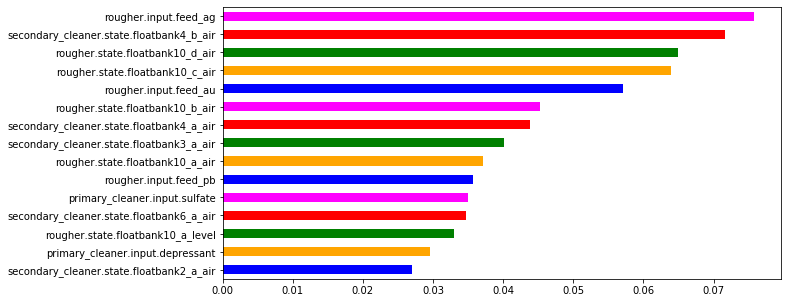

In [44]:
# оценка важности признаков на целевой признак rougher.output.recovery
top_features_rougher = importances(features_train_rougher, model_5, 0.01)

In [45]:
print(top_features_rougher )

0                primary_cleaner.input.sulfate
1             primary_cleaner.input.depressant
2       primary_cleaner.state.floatbank8_b_air
3       primary_cleaner.state.floatbank8_c_air
4                        rougher.input.feed_ag
5                        rougher.input.feed_pb
6                       rougher.input.feed_sol
7                        rougher.input.feed_au
8           rougher.input.floatbank10_xanthate
9            rougher.input.floatbank11_sulfate
10          rougher.input.floatbank11_xanthate
11             rougher.state.floatbank10_a_air
12           rougher.state.floatbank10_a_level
13             rougher.state.floatbank10_b_air
14             rougher.state.floatbank10_c_air
15           rougher.state.floatbank10_c_level
16             rougher.state.floatbank10_d_air
17           rougher.state.floatbank10_d_level
18             rougher.state.floatbank10_e_air
19           rougher.state.floatbank10_e_level
20    secondary_cleaner.state.floatbank2_a_air
21    seconda

Собререм список всех важных колонок

primary_cleaner.input.sulfate = 0.05235649072911554
primary_cleaner.input.depressant = 0.0632420133210307
primary_cleaner.input.xanthate = 0.021283286791289734
primary_cleaner.state.floatbank8_a_level = 0.010336945027205122
primary_cleaner.state.floatbank8_b_air = 0.026366836879138916
primary_cleaner.state.floatbank8_b_level = 0.056220883078335504
primary_cleaner.state.floatbank8_c_air = 0.02768156458038178
primary_cleaner.state.floatbank8_c_level = 0.009964975653530956
rougher.input.feed_ag = 0.13751076958628736
rougher.input.feed_pb = 0.03194987091443137
rougher.input.feed_size = 0.013552610451034758
rougher.input.feed_sol = 0.08997502547641997
rougher.input.feed_au = 0.09488120645633243
rougher.input.floatbank10_sulfate = 0.023072462975865345
rougher.input.floatbank10_xanthate = 0.03703108997093675
rougher.input.floatbank11_sulfate = 0.01730362364934483
rougher.input.floatbank11_xanthate = 0.04618389236482219
rougher.state.floatbank10_b_air = 0.00853859286314368
rougher.state.floatb

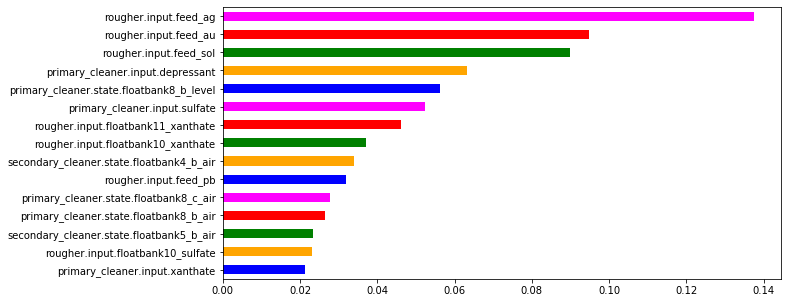

In [46]:
# оценка важности признаков на целевой признак final.output.recovery
top_features_final = importances(features_train_final, model_6, 0.008)
roughe_top = pd.Series(['rougher.output.concentrate_au', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_pb',
                        'rougher.input.feed_sol', 'rougher.output.concentrate_ag', 'final.output.recovery'])
top_features_final = top_features_final.append(roughe_top).reset_index(drop=True)

In [47]:
print("Список наиболее важных колонок \n", top_features_final)

Список наиболее важных колонок 
 0                  primary_cleaner.input.sulfate
1               primary_cleaner.input.depressant
2                 primary_cleaner.input.xanthate
3       primary_cleaner.state.floatbank8_a_level
4         primary_cleaner.state.floatbank8_b_air
5       primary_cleaner.state.floatbank8_b_level
6         primary_cleaner.state.floatbank8_c_air
7       primary_cleaner.state.floatbank8_c_level
8                          rougher.input.feed_ag
9                          rougher.input.feed_pb
10                       rougher.input.feed_size
11                        rougher.input.feed_sol
12                         rougher.input.feed_au
13             rougher.input.floatbank10_sulfate
14            rougher.input.floatbank10_xanthate
15             rougher.input.floatbank11_sulfate
16            rougher.input.floatbank11_xanthate
17               rougher.state.floatbank10_b_air
18               rougher.state.floatbank10_c_air
19               rougher.state.float

Создадим новый темп датафрейм с урезанным набором признаков и оценим творение

In [48]:
# список колонок согласно features_importance не особо важных при работе нашей модели
bug_list_temp = pd.Series(train.columns[~train.columns.isin(top_features_final)])

# создадим темповые датафреймы с минимальным набором колонок необходимых для предсказания 
train_temp = train.drop(bug_list_temp, axis=1)
test_temp = test.drop(bug_list_temp, axis=1)


In [49]:
# Добавим целевые признаки
train_temp[['rougher.output.recovery', 'final.output.recovery']] = train[['rougher.output.recovery', 'final.output.recovery']]
test_temp[['rougher.output.recovery', 'final.output.recovery']] = test[['rougher.output.recovery', 'final.output.recovery']]
print(f'Новый размер датафрейма train для теста {train_temp.shape}')
print(f'Новый размер датафрейма test для теста {test_temp.shape}')
print(f'Старый размер датафрейма train {train.shape}')
print(f'Старый размер датафрейма test {test.shape}')

Новый размер датафрейма train для теста (14738, 30)
Новый размер датафрейма test для теста (5117, 30)
Старый размер датафрейма train (14738, 54)
Старый размер датафрейма test (5117, 54)


In [50]:
# разделим наши выборки на таргет и признаки для 'rougher.output.recovery'
features_train_rougher_t, target_train_rougher_t = normal_separator(train_temp, 'rougher.output.recovery', 'final.output.recovery')
features_test_rougher_t, target_test_rougher_t = normal_separator(test_temp, 'rougher.output.recovery', 'final.output.recovery')
# разделим наши выборки на таргет и признаки для 'final.output.recovery'
features_train_final_t, target_train_final_t = normal_separator(train_temp, 'final.output.recovery', 'rougher.output.recovery')
features_test_final_t, target_test_final_t = normal_separator(test_temp, 'final.output.recovery', 'rougher.output.recovery')
 
 

Запускаем модель решающего дерева для сравнения результатов до обработки и после

In [51]:
# модель решающего дерева для rougher 
smape_dec_three_rougher_t, model_7 = model_predict(DecisionTreeRegressor(criterion='mse', max_depth=1,
                                                max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                                min_impurity_split=None, min_samples_leaf=9, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                random_state=54321), features_train_rougher_t, target_train_rougher_t,
                                                features_test_rougher_t, target_test_rougher_t, 'rougher_t'
                                                )

# модель решающего дерева для final
smape_dec_three_final_t, model_8 = model_predict(DecisionTreeRegressor(criterion='mse', max_depth=1,
                                                max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                                min_impurity_split=None, min_samples_leaf=9, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                random_state=54321), features_train_final_t, target_train_final_t,
                                                features_test_final_t, target_test_final_t, 'final_t'
                                                )
smape_sum_three_t = round(smape_total(smape_dec_three_rougher_t, smape_dec_three_final_t),2)
print(f'Итоговое sMAPE после удаления лишних признаков на тестовых данных по решающему дереву равно {smape_sum_three_t}')


Значения для  rougher_t
Средняя оценка качества модели по кросс-валидации: 8.065
sMAPE : 3.5873 
sMAPE константной модели : 4.1987 

Значения для  final_t
Средняя оценка качества модели по кросс-валидации: 11.006
sMAPE : 8.4575 
sMAPE константной модели : 8.0510 

Итоговое sMAPE после удаления лишних признаков на тестовых данных по решающему дереву равно 7.24


 <a id='2'></a>

In [52]:
%%time
# модель случайного леса для rougher 
smape_forest_rougher_test, model_9 = model_predict(RandomForestRegressor(n_estimators=40, max_depth=6, min_samples_leaf=6,
                                        min_samples_split=2, max_features='sqrt',min_impurity_decrease=0.0, criterion='mse',random_state=12345),
                                        features_train_rougher_t, target_train_rougher_t,
                                        features_test_rougher_t, target_test_rougher_t, 'forest_rougher'
                                       )

# модель случайного леса для final 
smape_forest_final_test, model_10 = model_predict(RandomForestRegressor(n_estimators=40, max_depth=6, min_samples_leaf=6,
                                        min_samples_split=2, max_features='sqrt',min_impurity_decrease=0.0, criterion='mse',random_state=12345),
                                        features_train_final_t, target_train_final_t,
                                        features_test_final_t, target_test_final_t, 'forest_final'
                                       )


smape_sum_forest_test = round(smape_total(smape_forest_rougher_test, smape_forest_final_test),2)
print('-----------------------------------------------------------------')
print(f'Итоговое sMAPE по случайному лесу на тестовых данных после удаления лишних признаков равно {smape_sum_forest_test}')
print(f'Итоговое sMAPE по случайному лесу до удаления лишних признаков равно {smape_sum_forest}')



Значения для  forest_rougher
Средняя оценка качества модели по кросс-валидации: 5.926
sMAPE : 3.8379 
sMAPE константной модели : 4.1987 

Значения для  forest_final
Средняя оценка качества модели по кросс-валидации: 9.049
sMAPE : 7.3194 
sMAPE константной модели : 8.0510 

-----------------------------------------------------------------
Итоговое sMAPE по случайному лесу на тестовых данных после удаления лишних признаков равно 6.45
Итоговое sMAPE по случайному лесу до удаления лишних признаков равно 6.45
Wall time: 9.49 s


По итогу работы случайного леса, видно что он может опережать константную модель на предсказаниях по тестовой выборке. Более сокращенная выборка точно такое же значение по итоговой смапе, но небольшую разницу по спаме отдельных предсказаний.

Пробуем Линеарную она тоже была огонь.

In [54]:
# модель линеарной регрессии для rougher 
smape_linear_rougher_test, model_11 = model_predict(LinearRegression(fit_intercept=True, normalize=False, copy_X=True),
                                        features_train_rougher_t, target_train_rougher_t,
                                        features_test_rougher_t, target_test_rougher_t, 'linear_rougher'
                                       )

# модель линеарной регрессии для final 
smape_linear_final_test, model_12 = model_predict(LinearRegression(fit_intercept=True, normalize=False, copy_X=True),
                                        features_train_final_t, target_train_final_t,
                                        features_test_final_t, target_test_final_t, 'linear_final'
                                       )


smape_sum_linear_test = round(smape_total(smape_linear_rougher_test, smape_linear_final_test),2)
print(f'Итоговое sMAPE по линеарной регрессии после удаления лишних признаков равно {smape_sum_linear_test}')
print(f'Итоговое sMAPE по линеарной регрессии до удаления лишних признаков равно {smape_sum_linear}')

Значения для  linear_rougher
Средняя оценка качества модели по кросс-валидации: 6.699
sMAPE : 3.9837 
sMAPE константной модели : 4.1987 

Значения для  linear_final
Средняя оценка качества модели по кросс-валидации: 11.511
sMAPE : 8.1609 
sMAPE константной модели : 8.0510 

Итоговое sMAPE по линеарной регрессии после удаления лишних признаков равно 7.12
Итоговое sMAPE по линеарной регрессии до удаления лишних признаков равно 7.17


ну как то средненько )) Хотя виден прирост в точности. 


### Вывод
* Данные с пропусками в начале имеют важнейшее значение, если мы имеем пропуска по целевым признакам нам нужны формулы которые с большой точностью смогут нам помочь в вычислении этих признаков. Если пропусков в пределах 10 % их все же лучше удалять. Гадать на заполненных по разным методам (медиана, среднее или порядковое) это губительно для точности.
* Сравнение на концентрации показало нам выбросы с 0 значениями, а так же мы нашли колонки с минусовыми значениями которые явно мешали бы моделям. Удаления таких явно ошибочных признаков (врядли можно предположить наличие 0 значений в руде в процессе работы когда идет обработка одного участка с равным распределением концентраций, скорее всего были поломки с сенсорах или ошибках записей). После очистки данные стали более логичные и реалистичные.
* Я надеюсь, я правильно написал формулу новой метрики и ее применение на кросс-валидации.
* Запуск трех разных моделей показал, как в предыдущих работах быстрое время на линеарной регрессии, лучшую точность предсказаний на лесе. Дерево в середине этих моделей, оно способно неплохо предсказывать и с небольшим временем работы. Если данные были бы все линейные и на начальном и на финальном этапе, лучше бы справилась Линеарная Регрессия наверное. Применения методов маcштабирования, урезания признаков особо сильного эффекта не дало. 
* Тестовую выборку лучше всех осилил Случайный Лес с уровнем по итоговой sMape 3.95. 
